In [1]:
%load_ext autoreload
%autoreload 2

from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import matplotlib as mpl
import matplotlib.dates as mdates
import seaborn as sns

from datetime import timedelta, date
import time
import os

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, setup_spacescope
from mechafil.power import forecast_power_stats, build_full_power_stats_df, scalar_or_vector_to_vector
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, compute_baseline_power_array
from mechafil.supply import forecast_circulating_supply_df

from joblib import Parallel, delayed
import dill as pickle
from joblib import parallel_backend
from joblib import wrap_non_picklable_objects


In [2]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)
n_jobs = 4

os.environ['PYTHONWARNINGS']='ignore::FutureWarning'

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# fix a date so that we are consistent in runs across days
#current_date = datetime.date(2023, 2, 8)
current_date = datetime.date(2023, 3, 25)
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2023, 1, 1)
start_day = (start_date - datetime.date(2020, 10, 15)).days

forecast_lenght = 365 * 9
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

## NOTE: This code uses mechaFIL in a non-standard way. To reproduce the results,
#   the `sdm_take2_analysis` branch of mechaFIL needs to be used - not the main branch.
#   https://github.com/protocol/filecoin-mecha-twin/tree/sdm_take2_analysis
# This comment is relevant as of 21-Feb-2023.

2023-01-01
2023-03-25
2032-03-22


In [3]:
auth_token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
setup_spacescope(auth_token)

In [4]:
# simulation
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
#intervention_date=datetime.date(2023,3,15)
intervention_date=datetime.date(2023,4,15)
qap_mode = 'basic-sdm'
all_sector_no_jump_config = {
    'type': 'noop',
    'num_days_shock_behavior': 360,
    'intervention_date': intervention_date,
    'simulation_start_date': current_date + datetime.timedelta(days=1),
    'sdm_onboard_before_intervention': False,
    'sdm_onboard_after_intervention': True,
    'sdm_renew_before_intervention': False,
    'sdm_renew_after_intervention': True
}
noop_config = {
    'type': 'noop',
    'num_days_shock_behavior': 360,
    'intervention_date': intervention_date,
    'simulation_start_date': current_date + datetime.timedelta(days=1),
    'sdm_onboard_before_intervention': False,
    'sdm_onboard_after_intervention': False,
    'sdm_renew_before_intervention': False,
    'sdm_renew_after_intervention': False
}

# seperating from the expensive MCMC loop
def preprocess_expirations():
    # expirations
    res = get_sector_expiration_stats(start_date, current_date,end_date)

    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]

    current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]

    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0
    
    return rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df

def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
            df_out[c] = df_out[c].clip(lower=1e-6)
    return df_out

def run_sim(fil_plus_rate:Union[float, np.array], 
            rb_onboard_power:[float, np.array], 
            renewal_rate:[float, np.array],
            sector_duration:int,
            duration_m:callable,
            use_noop_config=False)->pd.DataFrame():
    setup_spacescope(auth_token)
    sector_duration = int(sector_duration)
    future_renewal_rate = scalar_or_vector_to_vector(renewal_rate, forecast_lenght)
    renewal_rate_vec = np.concatenate([historical_renewal_rate,future_renewal_rate])
    
    if use_noop_config:
        iv_in = noop_config
    else:
        iv_in = all_sector_no_jump_config
    
    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        future_renewal_rate,
        fil_plus_rate,
        sector_duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=iv_in,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )

    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values
    
    # minting 
    mint_df = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
    )

    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        sector_duration,
        renewal_rate_vec,
        burnt_fil_vec,
        vest_df,
        mint_df,
        known_scheduled_pledge_release_full_vec,
        fil_plus_rate=fil_plus_rate,
        intervention_config=iv_in,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    return cil_df, power_df

def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, _, _ = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, _ , _ = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, _, _ = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    assert np.array_equal(forecast_rb_date_vec, forecast_rr_date_vec)
    assert np.array_equal(forecast_rr_date_vec, forecast_fpr_date_vec)
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred

def run_one_mc(i, fil_plus_rate, rb_onboard_power, renewal_rate, sector_duration_days, duration_multipler_fn):
    cil_df_i, power_df_i = run_sim(fil_plus_rate, rb_onboard_power, renewal_rate, sector_duration_days, duration_multipler_fn)
    cil_df_i['iter'] = i
    power_df_i['iter'] = i
        
    return cil_df_i, power_df_i

def run_sim_mc(fpr_preds, rbp_preds, rr_preds, sector_duration_days, duration_multiplier_callable)->pd.DataFrame:
    idxs = range(len(fpr_preds))
    results = Parallel(n_jobs=n_jobs)(delayed(run_one_mc)(i, 
                                                          fpr_preds[i,:], 
                                                          rbp_preds[i,:], 
                                                          rr_preds[i,:],
                                                          sector_duration_days,
                                                          duration_multiplier_callable
                                                         ) for i in tqdm(idxs))
    cil_df_results = [x[0] for x in results]
    power_df_results = [x[1] for x in results]
    
    cil_df = pd.concat(cil_df_results, ignore_index=True)
    cil_df['sector_duration_yr'] = int(sector_duration_days/365)
    cil_df.index = cil_df.date
    cil_df.drop('date', axis=1, inplace=True)
    
    power_df = pd.concat(power_df_results, ignore_index=True)
    power_df['sector_duration_yr'] = int(sector_duration_days/365)
    power_df.index = power_df.date
    power_df.drop('date', axis=1, inplace=True)
    
    return cil_df, power_df

# baseline storage function
def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)

# summary statistics of trajectory dynamics
def get_df_summary(df)->pd.DataFrame:
    df_summary = df.groupby(['date']).quantile([0.05,0.25,0.5,0.75,0.95]).reset_index(level=[0,1])
    df_summary.rename(columns = {'level_1':'quantile'}, inplace = True)
    return df_summary

# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_RBP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing

# add ROI to trajectory
def add_generated_quantities(df:pd.DataFrame)->pd.DataFrame:
    # add ROI to trajectory df
    roi_duration = 365 # for computing 1Y ROI
    df['day_pledge_per_QAP'] = SECTOR_SIZE * (df['day_locked_pledge']-df['day_renewed_pledge'])/(df['day_onboarded_power_QAP'])
    df['day_rewards_per_sector'] = SECTOR_SIZE * df.day_network_reward / df.network_QAP
    df['1y_return_per_sector'] = df[['iter','day_rewards_per_sector']].groupby('iter').rolling(roi_duration).sum().shift(-roi_duration+1).values.flatten()
    df['1y_sector_roi'] = df['1y_return_per_sector'] / df['day_pledge_per_QAP']
    
    return df

In [5]:
# separate expensive preprocessing from MCMC loop
rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df = preprocess_expirations()
vest_df = compute_vesting_trajectory_df(start_date, end_date)
_, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)
t_historical_rbp, historical_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)
t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)

In [6]:
def duration_master_fn(d, slope=1, clip=None):
    if d < round(365*1.5):
        return 1
    else:
        y1_slp1 = 1
        y2_slp1 = 2 - 183/365.
        x1_slp1 = round(365*1.5)
        x2_slp1 = 365*2
        m = (y2_slp1 - y1_slp1) / (x2_slp1 - x1_slp1)
        m *= slope
        # y-y1 = m*(x-x1)
        y = m*(d - x1_slp1) + y1_slp1
        if clip is not None:
            if y > clip:
                y = clip
        return y
    
# define duration multiplier callables - we need to redefine these callables to be compatible w/ mechaFIL
def no_sdm(d):
    return 1

def duration_m_slp_1_noclip(d):
    return duration_master_fn(d, slope=1, clip=None)

def duration_m_slp_1_clip3_5(d):
    return duration_master_fn(d, slope=1, clip=3.5)

def duration_m_slp_0_1_noclip(d):
    return duration_master_fn(d, slope=0.1, clip=None)

def duration_m_slp_0_15_noclip(d):
    return duration_master_fn(d, slope=0.15, clip=None)

def duration_m_slp_0_2_noclip(d):
    return duration_master_fn(d, slope=0.2, clip=None)

def duration_m_slp_0_25_noclip(d):
    return duration_master_fn(d, slope=0.25, clip=None)

def duration_m_slp_0_285_noclip(d):
    return duration_master_fn(d, slope=0.285, clip=None)

def duration_m_slp_0_3_noclip(d):
    return duration_master_fn(d, slope=0.3, clip=None)

def duration_m_slp_0_5_noclip(d):
    return duration_master_fn(d, slope=0.5, clip=None)


duration2callable = {
    (0,None): no_sdm,
    (1,None): duration_m_slp_1_noclip,
    (1,3.5): duration_m_slp_1_clip3_5,
    (0.1,None): duration_m_slp_0_1_noclip,
    (0.15,None): duration_m_slp_0_15_noclip,
    (0.2,None): duration_m_slp_0_2_noclip,
    (0.25,None): duration_m_slp_0_25_noclip,
    (0.285,None): duration_m_slp_0_285_noclip,
    (0.3,None): duration_m_slp_0_3_noclip,
    (0.5,None): duration_m_slp_0_5_noclip,
}

In [7]:
num_mcmc_samps = 1
fpr_config = .6  # can a float value between 0 and 1
rr_config = 'lasthistorical'   # can be 'mcmc', 'lasthistorical'
rbp_config = 'lasthistorical'  # can be 'mcmc', 'lasthistorical', or baseline

if fpr_config != 'mcmc' and rr_config != 'mcmc' and rbp_config != 'mcmc':
    num_mcmc_samps = 1  # no variation so no need to run multiple sims, it is deterministic

regimes_vec = ['data_conserved', 'fil_conserved']
exp_configs = []
for r in regimes_vec:
    x = [
        (0,None,1, r),  
        (.285,None,3, r),  
        (.285,None,5, r),  
        (1,None,3, r),  
        (1,None,5, r),  
    ]
    exp_configs.extend(x)

input_quantiles_by_duration_slp = {}
inputs_by_duration_slp = {}
for exp_config in exp_configs:
    duration_slp, sdm_clip, sector_duration_yr, regime = exp_config
    duration_m = duration2callable[(duration_slp, sdm_clip)]
    
    if regime == 'data_conserved':
        scale_rbp_by_sdm = False
        scale_rr_by_sdm = False
    elif regime == 'fil_conserved':
        scale_rbp_by_sdm = True
        scale_rr_by_sdm = True
    
    
    rbp_in = []
    rr_in = []
    fpr_in = []
    for i in range(num_mcmc_samps):
        sector_duration = sector_duration_yr * 365
        qap_scale_factor = duration_m(sector_duration)

        if rbp_config == 'mcmc':
            rbp_forecast = np.asarray(rb_onboard_power_pred[i,:])
        elif rbp_config == 'lasthistorical':
            rbp_forecast = np.ones(forecast_lenght) * historical_rbp[-1]
        else:
            raise ValueError("unsupported RBP config!")

        if rr_config == 'mcmc':
            rr_forecast = np.asarray(renewal_rate_pred[i,:])
        elif rr_config == 'lasthistorical':
            rr_forecast = np.ones(forecast_lenght) * historical_renewal_rate[-1]
        else:
            raise ValueError('Unsupported RR Config!')

        if fpr_config == 'mcmc':
            fpr_forecast = np.asarray(filplus_rate_pred[i,:])
        else:
            fpr_forecast = np.ones(forecast_lenght) * fpr_config
        
        if scale_rbp_by_sdm:
            rbp_forecast = rbp_forecast/qap_scale_factor
        if scale_rr_by_sdm:
            rr_forecast = rr_forecast/qap_scale_factor

        rbp_in.append(rbp_forecast)
        rr_in.append(rr_forecast)
        fpr_in.append(fpr_forecast)

    rbp_in = np.asarray(rbp_in)
    rr_in = np.asarray(rr_in)
    fpr_in = np.asarray(fpr_in)

    rbp_Q = np.quantile(rbp_in, [0.05,0.25,0.5,0.75,0.95], axis=0)
    rr_Q = np.quantile(rr_in, [0.05,0.25,0.5,0.75,0.95], axis=0)
    fpr_Q = np.quantile(fpr_in, [0.05,0.25,0.5,0.75,0.95], axis=0)

    inputs_df = pd.DataFrame()
    inputs_df['rbp_Q05'] = rbp_Q[0,:]
    inputs_df['rbp_Q25'] = rbp_Q[1,:]
    inputs_df['rbp_Q50'] = rbp_Q[2,:]
    inputs_df['rbp_Q75'] = rbp_Q[3,:]
    inputs_df['rbp_Q95'] = rbp_Q[4,:]

    inputs_df['rr_Q05'] = rr_Q[0,:]
    inputs_df['rr_Q25'] = rr_Q[1,:]
    inputs_df['rr_Q50'] = rr_Q[2,:]
    inputs_df['rr_Q75'] = rr_Q[3,:]
    inputs_df['rr_Q95'] = rr_Q[4,:]

    inputs_df['fpr_Q05'] = fpr_Q[0,:]
    inputs_df['fpr_Q25'] = fpr_Q[1,:]
    inputs_df['fpr_Q50'] = fpr_Q[2,:]
    inputs_df['fpr_Q75'] = fpr_Q[3,:]
    inputs_df['fpr_Q95'] = fpr_Q[4,:]

    input_quantiles_by_duration_slp[exp_config] = inputs_df
    inputs_by_duration_slp[exp_config] = {
        'rbp_in': rbp_in,
        'rr_in': rr_in,
        'fpr_in': fpr_in
    }

In [9]:
# add in a baseline rbp to perform counterfactual analysis
cfg_str = 'rbp_baseline'
if rr_config == 'mcmc':
    rr_forecast = np.asarray(renewal_rate_pred[i,:])
elif rr_config == 'lasthistorical':
    rr_forecast = np.ones(forecast_lenght) * historical_renewal_rate[-1]
else:
    raise ValueError('Unsupported RR Config!')

if fpr_config == 'mcmc':
    fpr_forecast = np.asarray(filplus_rate_pred[i,:])
else:
    fpr_forecast = np.ones(forecast_lenght) * fpr_config
    
# # to compute the baseline power counterfactual properly, we run the baseline config once
# # and compute the delta between baseline and actual rbp, then make adjustments such that it matches
guess=75
rbp_guess = np.ones(forecast_lenght)*guess
cil_df_baselineminting, _ = run_sim(fpr_forecast, rbp_guess, rr_forecast, 365*3, no_sdm, use_noop_config=True)
cil_df_baselineminting_fc = cil_df_baselineminting[cil_df_baselineminting['date'] >= current_date]
delta = ((cil_df_baselineminting_fc['network_baseline'] - cil_df_baselineminting_fc['network_RBP'])/EIB).diff().values
delta[0] = 0
delta = delta * 1024
rbp_match_baseline = rbp_guess + delta

inputs_by_duration_slp[cfg_str] = {
    'rbp_in': np.asarray([rbp_match_baseline]),
    'rr_in': np.asarray([rr_forecast]),
    'fpr_in': np.asarray([fpr_forecast])
}
exp_configs.insert(0, cfg_str)
rbp_in_df = pd.DataFrame()
rbp_in_df['rbp_Q50'] = rbp_match_baseline
rbp_in_df['rr_Q50'] = np.ones(forecast_lenght) * historical_renewal_rate[-1]
rbp_in_df['fpr_Q50'] = fpr_forecast[0:len(rr_forecast)]
input_quantiles_by_duration_slp[cfg_str] = rbp_in_df

In [10]:
cil_df_by_dur = {}
power_df_by_dur = {}

for exp_config in exp_configs:
    if exp_config == 'rbp_baseline':
        sdm_fn = no_sdm
        sector_duration_yr=3
    else:
        duration_slp, sdm_clip, sector_duration_yr, regime = exp_config
        duration_m = duration2callable[(duration_slp, sdm_clip)]
        sdm_fn = duration2callable[(duration_slp, sdm_clip)]

    input_dict = inputs_by_duration_slp[exp_config]
    cil_df, power_df = run_sim_mc(input_dict['fpr_in'], input_dict['rbp_in'], input_dict['rr_in'], sector_duration_yr*365, sdm_fn)

    cil_df_by_dur[exp_config] = cil_df
    power_df_by_dur[exp_config] = power_df

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
# add ROI & summary
df_summaries_dict = {}
power_df_summaries_dict = {}

for exp_config in exp_configs:
    cil_mcmc_df_yr = cil_df_by_dur[exp_config]
    cil_mcmc_df_roi_yr = add_generated_quantities(cil_mcmc_df_yr)
    cil_mcmc_df_summary_yr = get_df_summary(cil_mcmc_df_roi_yr)

    df_summaries_dict[exp_config] = cil_mcmc_df_summary_yr
    
    power_df_yr = power_df_by_dur[exp_config]
    power_df_summary_yr = get_df_summary(power_df_yr)
    power_df_summaries_dict[exp_config] = power_df_summary_yr

In [12]:
offline_folder = 'offline'
os.makedirs(offline_folder, exist_ok=True)
with open(os.path.join(offline_folder, 'results.pkl'), 'wb') as f:
    pickle.dump(df_summaries_dict, f)

In [13]:
offline_folder = 'offline'
with open(os.path.join(offline_folder, 'results.pkl'), 'rb') as f:
    df_summaries_dict = pickle.load(f)

In [14]:
exp_configs_to_plot = [
    'rbp_baseline',
    (0,None,1, 'data_conserved'), 
    (.285,None,3, 'data_conserved'), 
    (.285,None,5, 'data_conserved'), 
    (1,None,3, 'data_conserved'), 
    (1,None,5, 'data_conserved'), 
    (0,None,1, 'fil_conserved'), 
    (.285,None,3, 'fil_conserved'), 
    (.285,None,5, 'fil_conserved'), 
    (1,None,3, 'fil_conserved'), 
    (1,None,5, 'fil_conserved'), 
]

colors_ = [
    mpl.colormaps['Greys'],
    mpl.colormaps['Purples'],
    mpl.colormaps['Blues'],
    mpl.colormaps['Greens'],
    mpl.colormaps['Oranges'],
    mpl.colormaps['Reds']
]
cmap_access_vec = np.linspace(0.4,0.8, 2)
linestyles = ['-', '--', ':', '-.']
plot_kwargs_list = [
    {'color':'r', 'linestyle':':', 'label':'RBP=Baseline', "linewidth":4},
    {'color':colors_[0](cmap_access_vec[0]), 'linestyle':':', 'linewidth':4, 'label':'No-SDM[Dur=1Y/Conservation=Data]'},
    {'color':colors_[1](cmap_access_vec[0]), 'linestyle':':', 'linewidth':4, 'label':'SDM[m=0.285][Dur=3Y/Conservation=Data]'},
    {'color':colors_[2](cmap_access_vec[0]), 'linestyle':':', 'linewidth':4, 'label':'SDM[m=0.285][Dur=5Y/Conservation=Data]'},
    {'color':colors_[3](cmap_access_vec[0]), 'linestyle':':', 'linewidth':4, 'label':'SDM[m=1.0][Dur=3Y/Conservation=Data]'},
    {'color':colors_[4](cmap_access_vec[0]), 'linestyle':':', 'linewidth':4, 'label':'SDM[m=1.0][Dur=5Y/Conservation=Data]'},
    
    {'color':colors_[0](cmap_access_vec[1]), 'linestyle':'-', 'label':'No-SDM[Dur=1Y/Conservation=FIL]'},
    {'color':colors_[1](cmap_access_vec[1]), 'linestyle':'-', 'label':'SDM[m=0.285][Dur=3Y/Conservation=FIL]'},
    {'color':colors_[2](cmap_access_vec[1]), 'linestyle':'-', 'label':'SDM[m=0.285][Dur=5Y/Conservation=FIL]'},
    {'color':colors_[3](cmap_access_vec[1]), 'linestyle':'-', 'label':'SDM[m=1.0][Dur=3Y/Conservation=FIL]'},
    {'color':colors_[4](cmap_access_vec[1]), 'linestyle':'-', 'label':'SDM[m=1.0][Dur=5Y/Conservation=FIL]'},
]

In [15]:
# baseline crossing plots
plt_max = date(2029, 1, 1)

def plt_network_metrics(df_summaries_by_dur,
                        scale_by=EIB, 
                        sup_title_str='',
                        smooth_by=1,
                        save_fp=None):
    # define plot settings and palette
    plt.rcParams.update({'font.size': 18})
    plt.rcParams["figure.figsize"] = (18,18)
    
    
    fig, axs = plt.subplots(4,2, constrained_layout=True)
    rolling_fn = lambda x: np.nanmedian(x)
    
    for ii, exp_config in enumerate(exp_configs_to_plot):
        plt_kwargs = plot_kwargs_list[ii]
        
        cil_df_summary = df_summaries_by_dur[exp_config]
        cil_df_summary = cil_df_summary[cil_df_summary['date'] <= pd.to_datetime(plt_max)]

        # select plotting data
        dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
        q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_RBP'] / scale_by
        bl = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_baseline'] / scale_by
        # plot RBP predictions
        axs[0,0].plot(dates_, q50_t, **plt_kwargs)
        axs[0,0].tick_params(axis='x', labelrotation = 30)
        axs[0,0].set_title('Network RBP')
        axs[0,0].set_ylabel('EiB')
        axs[0,0].set_yscale('log')
        if ii == 0:
            axs[0,0].axvline(intervention_date, color='k', linestyle=':', linewidth=2.5)
            axs[0,0].axvline(current_date, color='k', linestyle='--', linewidth=2.5)

        dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
        q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_QAP'] / scale_by
        # plot QAP predictions
        axs[0,1].plot(dates_, q50_t, **plt_kwargs)
        axs[0,1].tick_params(axis='x', labelrotation = 30)
        axs[0,1].set_title('Network QAP')
        axs[0,1].set_ylabel('EiB')
        axs[0,1].set_yscale('log')
        axs[0,1].set_ylim(0,150)
        if ii == 0:
            axs[0,1].axvline(intervention_date, color='k', linestyle=':', linewidth=2.5)
            axs[0,1].axvline(current_date, color='k', linestyle='--', linewidth=2.5)

        # plot pledge per sector
        w = 7
        dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
        q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_pledge_per_QAP'] 
        q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_pledge_per_QAP']
        q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_pledge_per_QAP']
        q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_pledge_per_QAP']
        q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_pledge_per_QAP']
        axs[1,0].plot(dates_, q50_t.rolling(w).apply(rolling_fn), **plt_kwargs)
        axs[1,0].tick_params(axis='x', labelrotation = 30)
        axs[1,0].set_title('Pledge per 32 GiB')
        if ii == 0:
            axs[1,0].axvline(intervention_date, color='k', linestyle=':', linewidth=2.5, label='SDM Start')
            axs[1,0].axvline(current_date, color='k', linestyle='--', linewidth=2.5, label='Simulation Start')
        axs[1,0].set_ylabel('FIL')
        
        # plot network reward
        dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
        q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['day_network_reward'] 
        q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['day_network_reward'] 
        q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['day_network_reward'] 
        q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['day_network_reward']
        q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['day_network_reward']
        axs[1,1].plot(dates_, q50_t.rolling(7).apply(rolling_fn), **plt_kwargs)
        axs[1,1].tick_params(axis='x', labelrotation = 30)
        axs[1,1].set_title('Minting')
        axs[1,1].set_ylabel('FIL/day')
        axs[1,1].set_ylim(0,)
        if ii == 0:
            axs[1,1].axvline(intervention_date, color='k', linestyle=':', linewidth=2.5, label='SDM Start')
            axs[1,1].axvline(current_date, color='k', linestyle='--', linewidth=2.5, label='Simulation Start')

        # plot roi
        dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
        q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['1y_sector_roi'] * 100
        q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['1y_sector_roi']  * 100
        q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['1y_sector_roi'] * 100
        q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['1y_sector_roi'] * 100
        q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['1y_sector_roi'] * 100
        axs[2,1].plot(dates_, q50_t.rolling(7).apply(rolling_fn), **plt_kwargs)
        axs[2,1].tick_params(axis='x', labelrotation = 30)
#         axs[2,1].set_title('1y sector ROI')
        axs[2,1].set_title('1y sector returns multiple')
        axs[2,1].set_ylabel('%')
        axs[2,1].set_ylim(0,100)
        xt = axs[2,1].get_xticks()
        xl = axs[2,1].get_xlim()
        if ii == 0:
            axs[2,1].axvline(intervention_date, color='k', linestyle=':', linewidth=2.5, label='SDM Start')
            axs[2,1].axvline(current_date, color='k', linestyle='--', linewidth=2.5, label='Simulation Start')

        # plot daily locked pledge
        dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
        kk = 'day_locked_pledge'; ktitle = 'Daily Locked Pledge'
        q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)][kk] 
        q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)][kk] 
        q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)][kk] 
        q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)][kk] 
        q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)][kk] 
        axs[2,0].plot(dates_, q50_t.rolling(7).apply(rolling_fn), **plt_kwargs)
        axs[2,0].tick_params(axis='x', labelrotation = 30)
        axs[2,0].set_title(ktitle)
        axs[2,0].set_ylabel('FIL/day')
        axs[2,0].set_yscale('log')
        if ii == 0:
            axs[2,0].axvline(intervention_date, color='k', linestyle=':', linewidth=2.5, label='SDM Start')
            axs[2,0].axvline(current_date, color='k', linestyle='--', linewidth=2.5, label='Simulation Start')

        # plot network locked
        dates_ = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['date']
        q05_t = cil_df_summary[(cil_df_summary['quantile'] == 0.05)]['network_locked'] / 1e6
        q25_t = cil_df_summary[(cil_df_summary['quantile'] == 0.25)]['network_locked'] / 1e6 
        q50_t = cil_df_summary[(cil_df_summary['quantile'] == 0.5)]['network_locked'] / 1e6 
        q75_t = cil_df_summary[(cil_df_summary['quantile'] == 0.75)]['network_locked'] / 1e6
        q95_t = cil_df_summary[(cil_df_summary['quantile'] == 0.95)]['network_locked'] / 1e6
        axs[3,0].plot(dates_, q50_t.rolling(7).apply(rolling_fn), **plt_kwargs)
        axs[3,0].tick_params(axis='x', labelrotation = 30)
        axs[3,0].set_title('Network locked')
        axs[3,0].set_ylabel('M-FIL')
        if ii == 0:
            axs[3,0].axvline(intervention_date, color='k', linestyle=':', linewidth=2.5)
            axs[3,0].axvline(current_date, color='k', linestyle='--', linewidth=2.5)
        
        axs[3,1].set_frame_on(False)
        axs[3,1].get_xaxis().set_visible(False)
        axs[3,1].get_yaxis().set_visible(False)
        axs[3,1].plot(0,0,**plt_kwargs)
        axs[3,1].legend(fontsize=14)
        

    plt.suptitle(sup_title_str)
    plt.tight_layout()
    
    if save_fp is not None:
        plt.savefig(save_fp)

In [16]:
df_summaries_dict['rbp_baseline'].columns

Index(['date', 'quantile', 'days', 'circ_supply', 'network_gas_burn',
       'day_locked_pledge', 'day_renewed_pledge', 'network_locked_pledge',
       'network_locked', 'network_locked_reward', 'disbursed_reserve',
       'pledge_delta', 'onboards_delta', 'renews_delta',
       'scheduled_pledge_release', 'day_onboard_pledge', 'total_vest',
       'network_RBP', 'network_QAP', 'day_onboarded_power_QAP',
       'day_renewed_power_QAP', 'cum_simple_reward', 'network_baseline',
       'capped_power', 'cum_capped_power', 'network_time',
       'cum_baseline_reward', 'cum_network_reward', 'day_network_reward',
       'iter', 'sector_duration_yr', 'day_pledge_per_QAP',
       'day_rewards_per_sector', '1y_return_per_sector', '1y_sector_roi'],
      dtype='object')

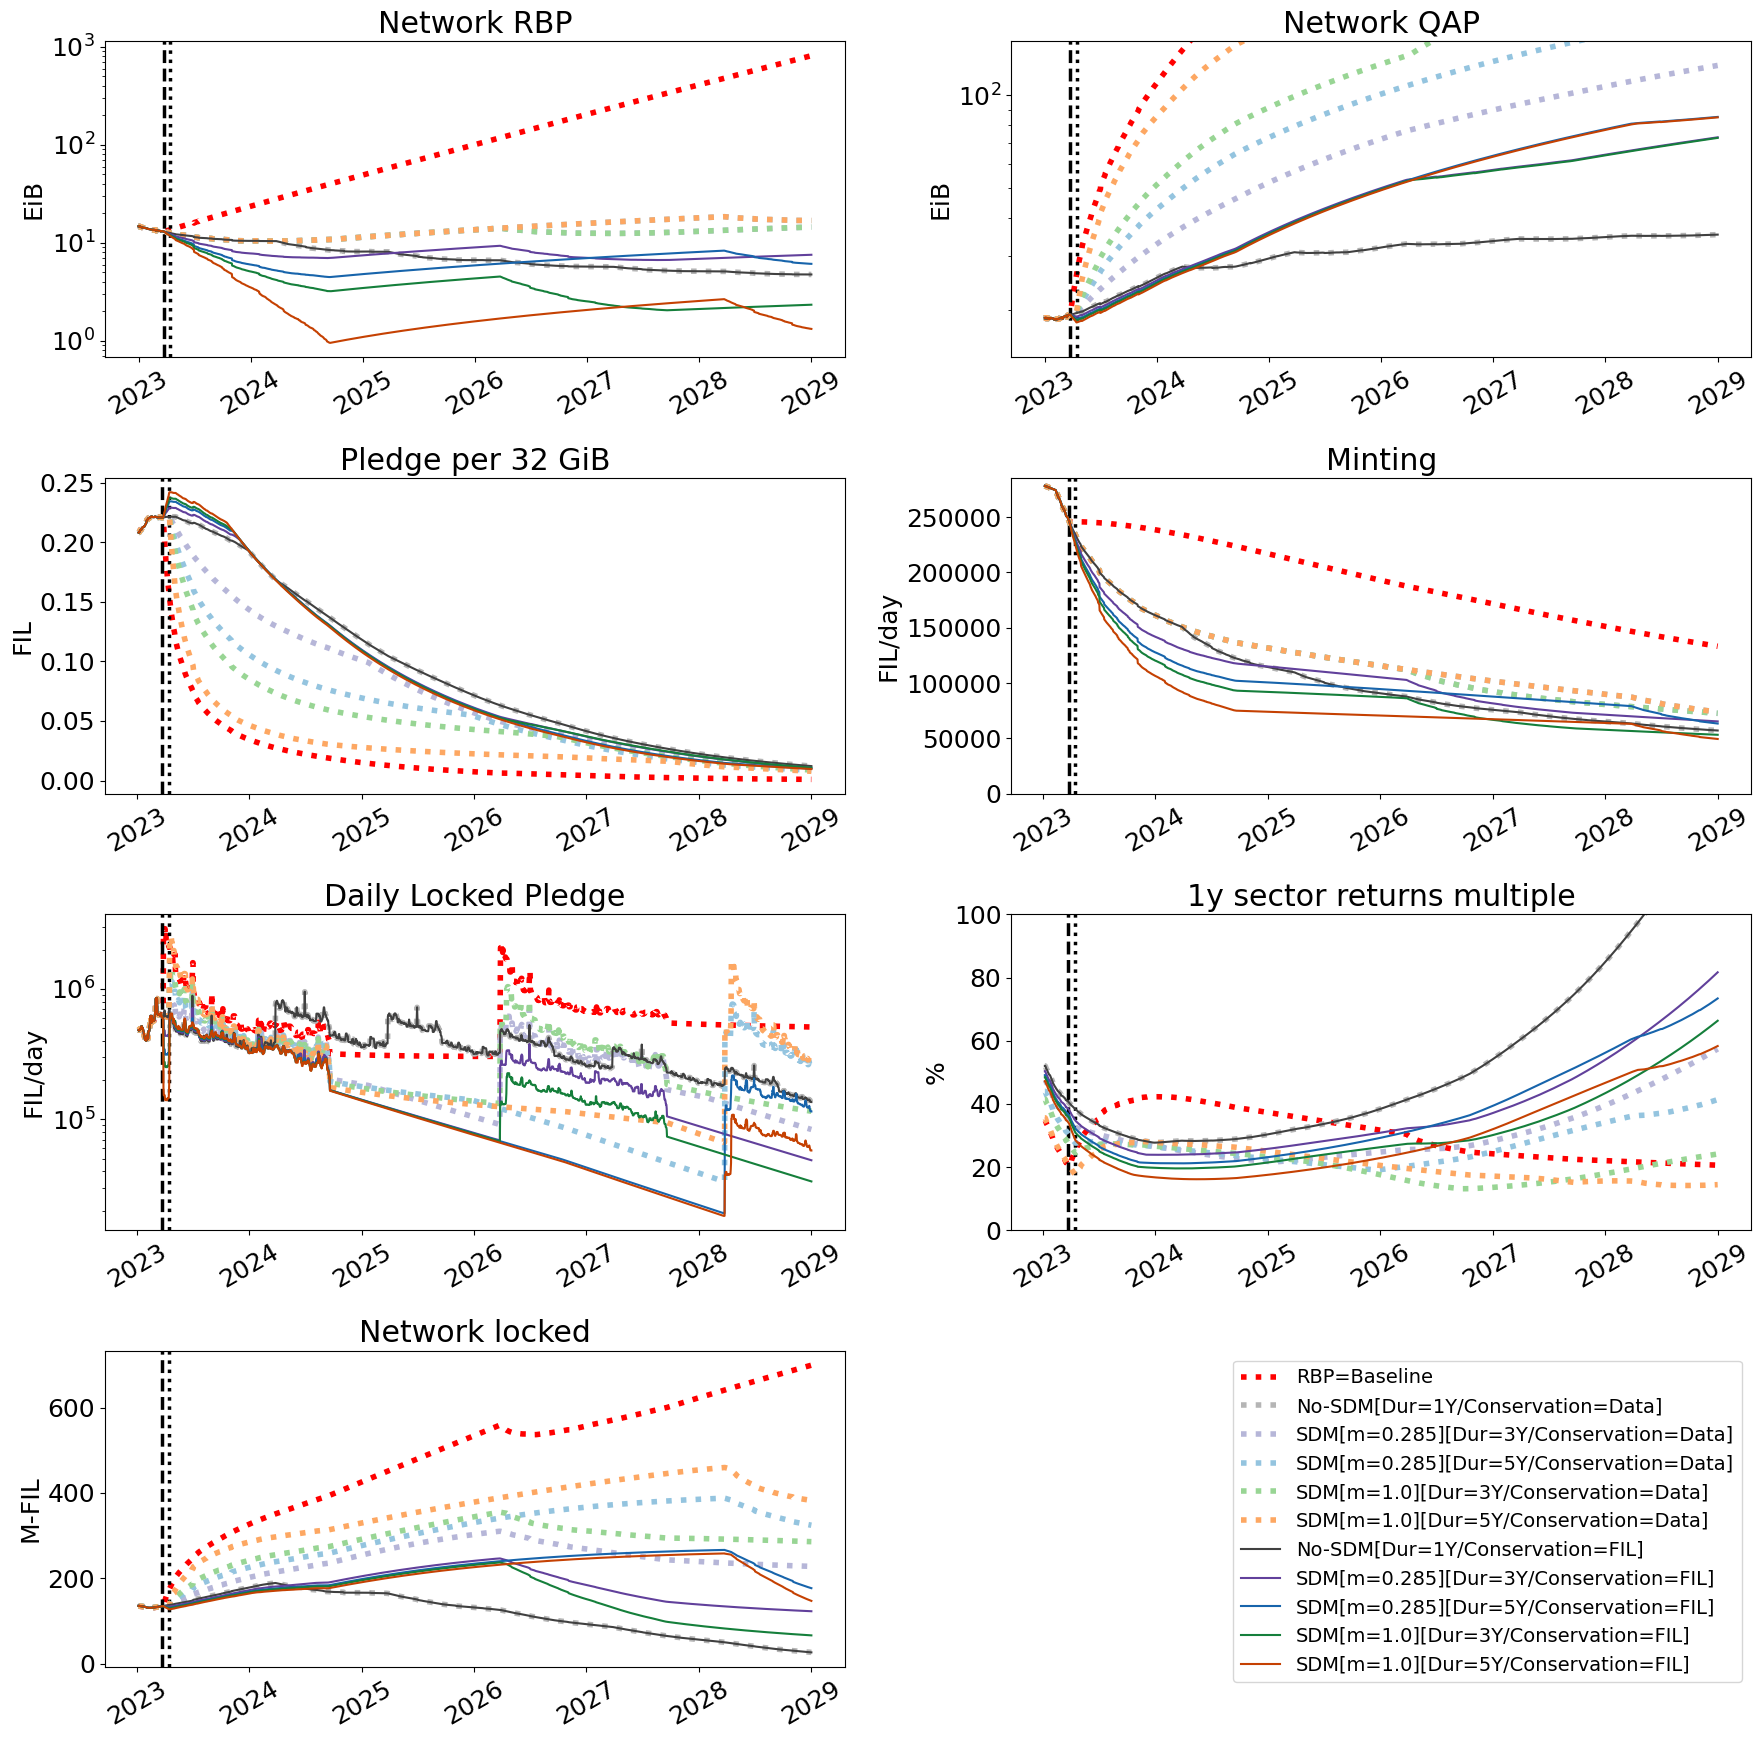

In [17]:
save_folder = '/Users/kiran/Documents/hackmd/sdm_slopes/'
tym = int(time.time())
fpr_str = 'mcmc' if fpr_config == 'mcmc' else '%0.02f' % (fpr_config,)
save_fp = 'rbp-%s_rr-%s_fpr-%s.png' % \
    (rbp_config,rr_config,fpr_str)

plt_network_metrics(df_summaries_dict, 
                    scale_by=EIB,
                    save_fp=os.path.join(save_folder, save_fp))

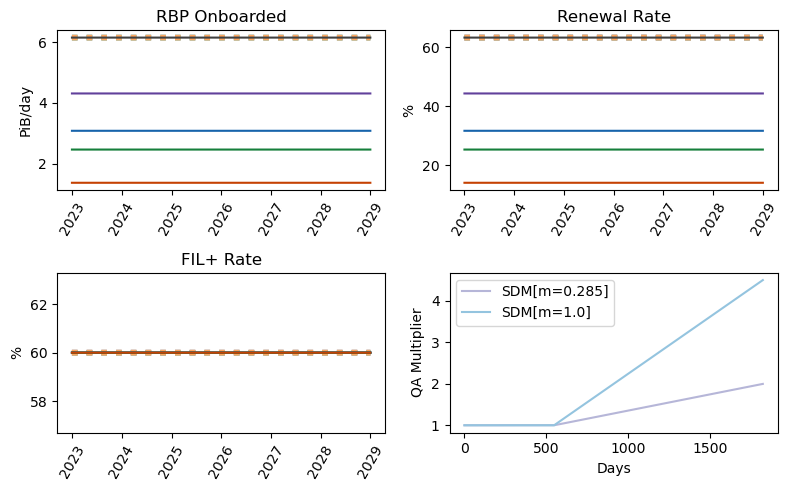

In [18]:
# plot the inputs
import copy 

plt.figure(figsize=(8,5))

num_days_plot = (plt_max - start_date).days
t = [start_date + datetime.timedelta(days=i) for i in range(num_days_plot)]
plt.rcParams.update({'font.size': 10})

plt.subplot(2,2,1)

for ii, exp_config in enumerate(exp_configs_to_plot):
#     duration_slp, sdm_clip, sector_duration_yr = exp_config
    if exp_config == 'rbp_baseline':
        continue
    plt_kwargs = plot_kwargs_list[ii]
    
    inputs_df = input_quantiles_by_duration_slp[exp_config]
    plt.plot(t, inputs_df['rbp_Q50'].values[0:num_days_plot], **plt_kwargs)
            
plt.tick_params(axis='x', labelrotation = 60)
plt.title('RBP Onboarded')
plt.ylabel('PiB/day')
# plt.legend()

plt.subplot(2,2,2)
for ii, exp_config in enumerate(exp_configs_to_plot):
#     duration_slp, sdm_clip, sector_duration_yr = exp_config
    plt_kwargs = plot_kwargs_list[ii]
    
    inputs_df = input_quantiles_by_duration_slp[exp_config]
    plt.plot(t, inputs_df['rr_Q50'].values[0:num_days_plot]*100, **plt_kwargs)
plt.tick_params(axis='x', labelrotation = 60)
plt.title('Renewal Rate')
plt.ylabel('%')
# plt.legend()

plt.subplot(2,2,3)
for ii, exp_config in enumerate(exp_configs_to_plot):
#     duration_slp, sdm_clip, sector_duration_yr = exp_config
    plt_kwargs = plot_kwargs_list[ii]
    
    inputs_df = input_quantiles_by_duration_slp[exp_config]
    plt.plot(t, inputs_df['fpr_Q50'].values[0:num_days_plot]*100, **plt_kwargs)
plt.tick_params(axis='x', labelrotation = 60)
plt.title('FIL+ Rate')
plt.ylabel('%')

# plot duration multipliers
plt.subplot(2,2,4)
days_vec = np.arange(0,365*5)


sdms_to_plot = [
    (.285,None,3, 'data_conserved'), 
    (1,None,3, 'data_conserved')
]
sdm_plt_kwargs = [
    {'color':colors_[1](cmap_access_vec[0]), 'linestyle':'-', 'label':'SDM[m=0.285]'},
    {'color':colors_[2](cmap_access_vec[0]), 'linestyle':'-', 'label':'SDM[m=1.0]'},
]
for ii, exp_config in enumerate(sdms_to_plot):
    if isinstance(exp_config, tuple):
        duration_slp, sdm_clip, sector_duration_yr, regime = exp_config

        plt_kwargs = sdm_plt_kwargs[ii]
        duration_m = duration2callable[(duration_slp, sdm_clip)]
        dur_m_vec = np.zeros(len(days_vec))
        for d in days_vec:
            dur_m_vec[d] = duration_m(d)
        plt.plot(days_vec, dur_m_vec, **plt_kwargs)
plt.xlabel('Days')
plt.ylabel('QA Multiplier')
plt.legend(fontsize=10, loc='upper left')

# plt.suptitle('Inputs')
plt.tight_layout()

save_fp = 'inputs-rbp-%s_rr-%s_fpr-%s.png' % \
    (rbp_config,rr_config,fpr_str)
    
plt.savefig(os.path.join(save_folder, save_fp))

In [69]:
#power_df_summaries_dict.keys()
power_df_summaries_dict['rbp_baseline'].columns

Index(['date', 'quantile', 'total_raw_power_eib', 'total_qa_power_eib',
       'day_onboarded_qa_power_pib', 'day_renewed_qa_power_pib',
       'total_rb_power_eib', 'day_onboarded_rb_power_pib',
       'rb_sched_expire_power', 'rb_sched_expire_power_known',
       'rb_sched_expire_power_model', 'day_renewed_rb_power_pib',
       'qa_sched_expire_power', 'qa_sched_expire_power_known',
       'qa_sched_expire_power_model', 'iter', 'sector_duration_yr'],
      dtype='object')

In [72]:
def plot_expirations(df_summaries_by_dur,
                     scale_by=EIB, 
                     sup_title_str='',
                     smooth_by=1,
                     save_fp=None,
                     include_filter=None,
                     filter2=None):
    # define plot settings and palette
    plt.rcParams.update({'font.size': 14})
    plt.rcParams["figure.figsize"] = (10,6)
    
    
    fig, axs = plt.subplots(2,2, constrained_layout=True)
    rolling_fn = lambda x: np.nanmedian(x)
    
    for ii, exp_config in enumerate(exp_configs_to_plot):
        if exp_config == 'rbp_baseline':
            continue
        if include_filter not in exp_config[3]:
            continue
        if filter2 == exp_config[0]:
            continue
        plt_kwargs = plot_kwargs_list[ii]
        
        power_df_summary = df_summaries_by_dur[exp_config]
        power_df_summary = power_df_summary[power_df_summary['date'] <= pd.to_datetime(plt_max)]

        # select plotting data
        dates_ = power_df_summary['date']
        axs[0,0].plot(dates_, power_df_summary['rb_sched_expire_power_model'], **plt_kwargs)
        axs[0,0].tick_params(axis='x', labelrotation = 30)
        axs[0,0].set_title('RB Expirations [Modeled Sectors]')
        axs[0,0].set_ylabel('PiB')

        dates_ = power_df_summary['date']
        axs[0,1].plot(dates_, power_df_summary['qa_sched_expire_power_model'], **plt_kwargs)
        axs[0,1].tick_params(axis='x', labelrotation = 30)
        axs[0,1].set_title('QA Expirations [Modeled Sectors]')
        axs[0,1].set_ylabel('PiB')

        axs[1,0].set_frame_on(False)
        axs[1,0].get_xaxis().set_visible(False)
        axs[1,0].get_yaxis().set_visible(False)
        
        axs[1,1].set_frame_on(False)
        axs[1,1].get_xaxis().set_visible(False)
        axs[1,1].get_yaxis().set_visible(False)
        axs[1,1].plot(0,0,**plt_kwargs)
        axs[1,1].legend(fontsize=12)
        
    plt.savefig(save_fp)

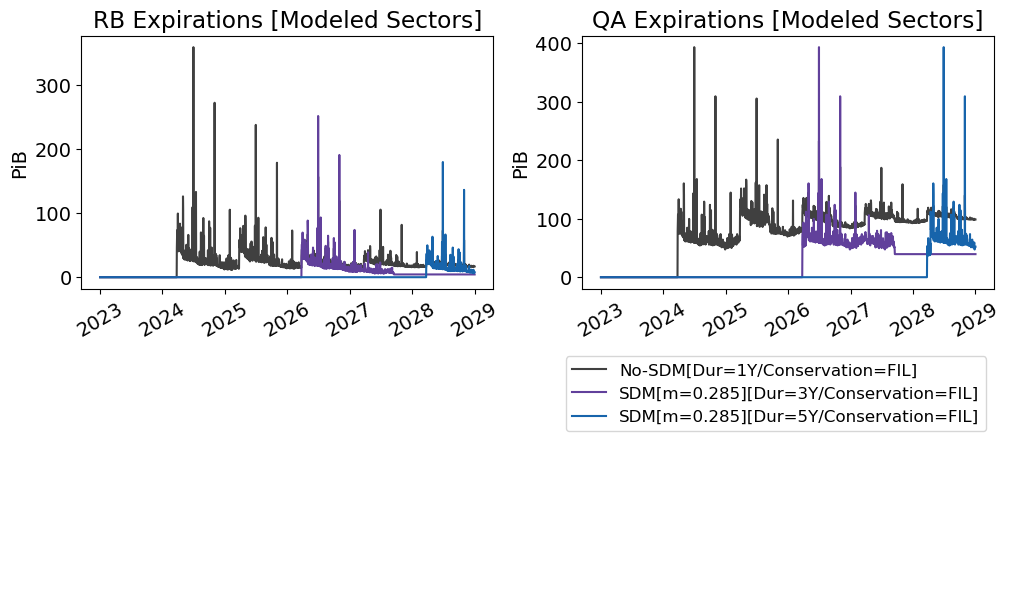

In [73]:
save_fp = 'expirations-rbp-%s_rr-%s_fpr-%s.png' % \
    (rbp_config,rr_config,fpr_str)

plot_expirations(power_df_summaries_dict, 
                 scale_by=EIB,
                 save_fp=os.path.join(save_folder, save_fp),
                 include_filter='fil_conserved',
                 filter2=1)
